In [156]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

In [158]:
premier_league = pd.read_csv("./datasets/Premier League.csv")
premier_league.loc[premier_league['Home Team Goals']>premier_league['Away Team Goals'], 'Winner'] = 0
premier_league.loc[premier_league['Home Team Goals']<premier_league['Away Team Goals'], 'Winner'] = 1
premier_league.loc[premier_league['Home Team Goals']==premier_league['Away Team Goals'], 'Winner'] = 2
premier_league.head()

,year,Home Team,Away Team,Home Team Goals,Away Team Goals,Winner
0,1993,Arsenal,Coventry,0,3,1.0
1,1993,Aston Villa,QPR,4,1,0.0
2,1993,Chelsea,Blackburn,1,2,1.0
3,1993,Liverpool,Sheffield Weds,2,0,0.0
4,1993,Man City,Leeds,1,1,2.0


# First prediction

<img src='./pictures/prem.png'>
     
### Dataset: Premier League 2020 with final scores
### Trainning: 30 firsts rounds
### Testing: 8 final rounds

#### We want to check if given final results all the classifiers are "clever" enough to predict the winner 

In [159]:
premierleague2020 = premier_league[premier_league['year'] == 2020]

teams = premierleague2020['Home Team'].unique()
teams.sort()

mapping = {team: index for index ,team in enumerate(teams) }
premierleague2020 = premierleague2020.replace({'Home Team': mapping, 'Away Team': mapping})
premierleague2020

,year,Home Team,Away Team,Home Team Goals,Away Team Goals,Winner
10424,2020,7,0,0,3,1.0
10425,2020,5,15,1,0,0.0
10426,2020,10,8,4,3,0.0
10427,2020,18,13,0,2,1.0
10428,2020,17,9,0,3,1.0
...,...,...,...,...,...,...
10799,2020,10,5,2,0,0.0
10800,2020,11,6,5,0,0.0
10801,2020,14,3,1,0,0.0
10802,2020,18,15,3,0,0.0


#### We expect from the classifiers to predict with very high accuracy (since the final result is known)

In [160]:
from sklearn.model_selection import train_test_split

X, y = premierleague2020.iloc[:,1:-1], premierleague2020.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=300 , shuffle=False)

### Logistic Regression

In [161]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix

lgr = LogisticRegression()
lgr.fit(X_train,y_train)

print('Logistic Regression Accuracy: ', lgr.score(X_test,y_test),"\n")

y_pred = lgr.predict(X_test)

print("Logistic Regression Matrix:")
print( confusion_matrix(y_test,y_pred),"\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))


Logistic Regression Accuracy:  1.0 

Logistic Regression Matrix:
[[32  0  0]
 [ 0 35  0]
 [ 0  0 13]] 

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        32
         1.0       1.00      1.00      1.00        35
         2.0       1.00      1.00      1.00        13

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



We are not supprised by the result as the prediction can be done with a simple mathematical calculation:
("Home Team Goals" - "Away Team Goals").

Then the logistic classifier can decide whether the winner is (using sigmoid function) the home team or the away team.

### Decision Trees

In [162]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

dt=DecisionTreeClassifier()
dt.fit(X_train,y_train)
print('Decision Tree Accuracy : ', dt.score(X_test,y_test),"\n")

y_pred = dt.predict(X_test)

print("Decision Tree Matrix:")
print(confusion_matrix(y_test,y_pred),"\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Decision Tree Accuracy :  1.0 

Decision Tree Matrix:
[[32  0  0]
 [ 0 35  0]
 [ 0  0 13]] 

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        32
         1.0       1.00      1.00      1.00        35
         2.0       1.00      1.00      1.00        13

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



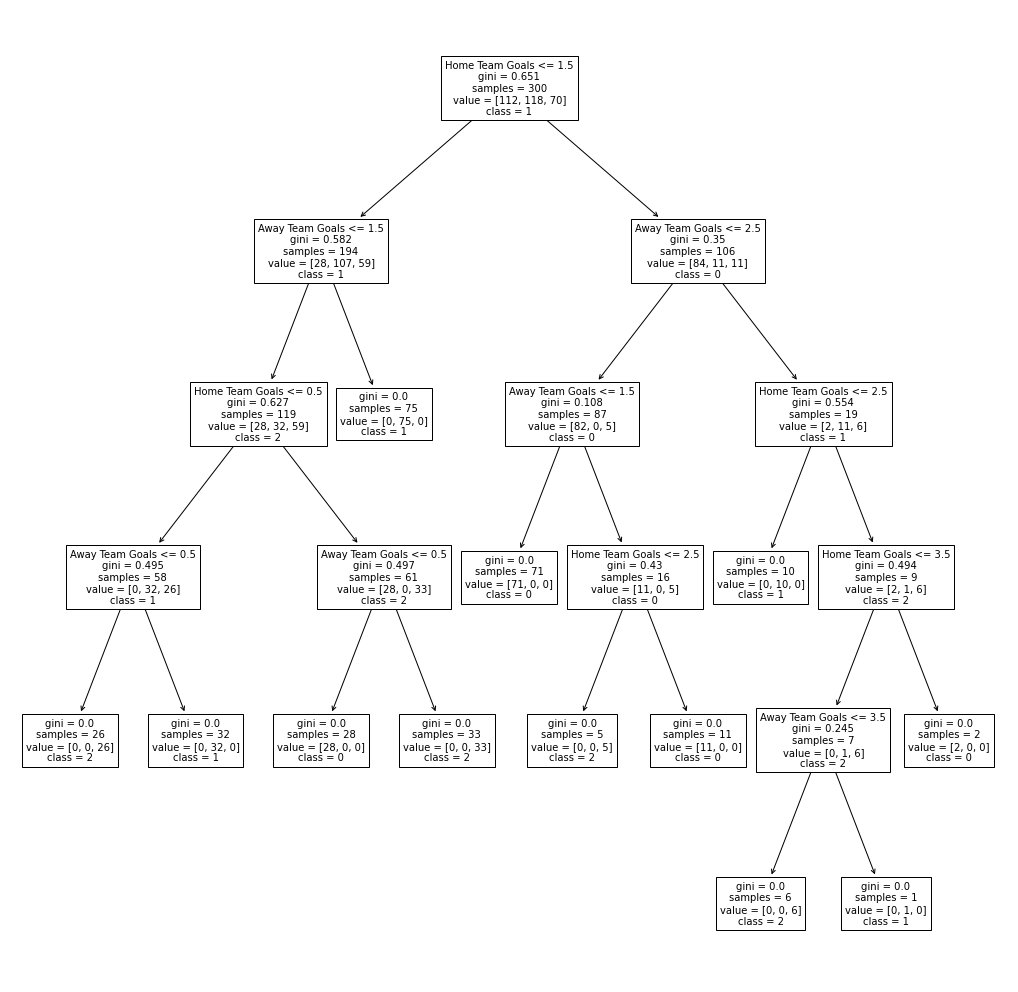

In [163]:
plt.figure(figsize=(18,18))  # set plot size (denoted in inches)
plot_tree(dt, feature_names=X.columns, class_names = ['0','1', '2'], fontsize=10)
plt.show()

In [164]:
X_train[(X_train['Home Team Goals'] == 1 ) & (X_train['Away Team Goals'] == 1 )].count()

Home Team          33
Away Team          33
Home Team Goals    33
Away Team Goals    33
dtype: int64

### AdaBoost

using Decision Tree of depth 1

In [165]:
from sklearn.ensemble import AdaBoostClassifier

adb= AdaBoostClassifier(n_estimators=1000)
adb.fit(X_train,y_train)
print('AdaBoost Accuracy : ', adb.score(X_test,y_test),"\n")

y_pred = adb.predict(X_test)

print("AdaBoost Matrix:")
print(confusion_matrix(y_test,y_pred),"\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

AdaBoost Accuracy :  0.7375 

AdaBoost Matrix:
[[17  0 15]
 [ 0 29  6]
 [ 0  0 13]] 

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.53      0.69        32
         1.0       1.00      0.83      0.91        35
         2.0       0.38      1.00      0.55        13

    accuracy                           0.74        80
   macro avg       0.79      0.79      0.72        80
weighted avg       0.90      0.74      0.76        80



The above AdaBoost classifer use a Decision Tree of depth 1 as weak learner (base_estimator), and as we can see from the Decision Tree classification above, 1 question is not enough...  

Let's try with a better "weak" classifier.

### AdaBoost

using Decision Trees of depth 2

In [166]:
adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2) ,n_estimators=50)
adaboost.fit(X_train,y_train)
print('AdaBoost Accuracy : ', adaboost.score(X_test,y_test),"\n")

y_pred = adaboost.predict(X_test)

print("AdaBoost Matrix:")
print(confusion_matrix(y_test,y_pred),"\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

AdaBoost Accuracy :  1.0 

AdaBoost Matrix:
[[32  0  0]
 [ 0 35  0]
 [ 0  0 13]] 

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        32
         1.0       1.00      1.00      1.00        35
         2.0       1.00      1.00      1.00        13

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



After "boosting" the model we got perfect results.  

### Naive Bayes

In [167]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train,y_train)
print('Naive Bayes Accuracy : ', nb.score(X_test,y_test),"\n")

y_pred = nb.predict(X_test)

print("Naive Bayes Matrix:")
print(confusion_matrix(y_test,y_pred),"\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Naive Bayes Accuracy :  0.925 

Naive Bayes Matrix:
[[29  0  3]
 [ 0 32  3]
 [ 0  0 13]] 

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95        32
         1.0       1.00      0.91      0.96        35
         2.0       0.68      1.00      0.81        13

    accuracy                           0.93        80
   macro avg       0.89      0.94      0.91        80
weighted avg       0.95      0.93      0.93        80



Works ok but not perfectly, since Naive Bayes classifier assumes that the effect of a particular feature in a class is independent of other features, which is not our case...

The winner class depends on both "Home team goals" and "Away team goals"